# Day 5: Time Series Forecasting - ARIMA & XGBoost

## Section 1: Classical Forecasting - ARIMA
### Autocorrelation (ACF) and Partial Autocorrelation (PACF)
These help identify the lag structure of the time series.
- ACF shows correlation between the time series and its lags.
- PACF controls for indirect effects.

Plot ACF and PACF for the Airline dataset.

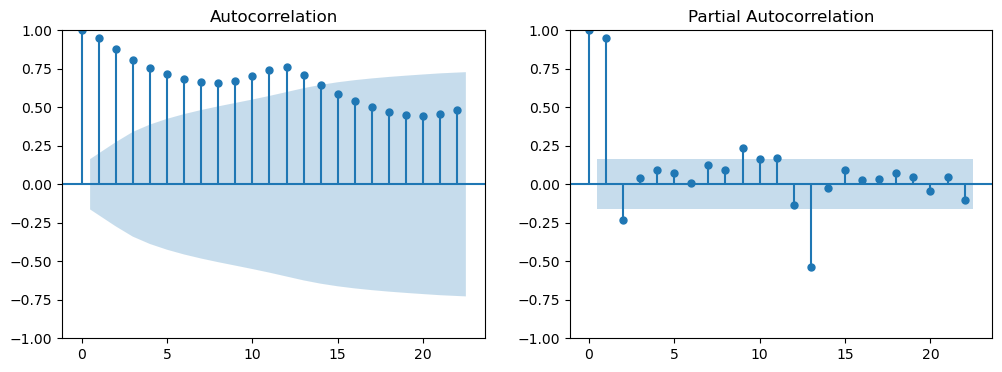

In [2]:
from sktime.datasets import load_airline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

y = load_airline()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(y, ax=axes[0])
plot_pacf(y, ax=axes[1])
plt.show()

### Fit an ARIMA model
Use statsmodels to fit an ARIMA(p,d,q) model.

/home/dominik/miniforge3/lib/python3.12/site-packages/sktime/forecasting/base/_fh.py:400: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/home/dominik/miniforge3/lib/python3.12/site-packages/sktime/forecasting/base/_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
/home/dominik/miniforge3/lib/python3.12/site-packages/sktime/forecasting/base/_fh.py:400: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/home/dominik/miniforge3/lib/python3.12/site-packages/sktime/forecasting/base/_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
/home/dominik/miniforge3/lib/python3.12/site-packages/sktime/utils/datetime.py:73: FutureWarning: 'M' is deprecated and 

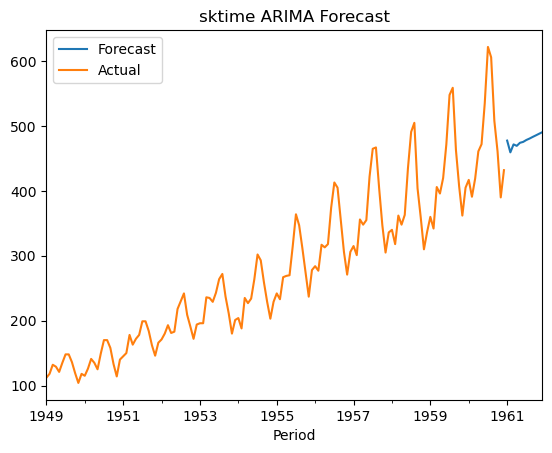

In [3]:
from sktime.forecasting.arima import ARIMA

forecaster = ARIMA(order=(1,1,1))
forecaster.fit(y)
fh = list(range(1, 13))
y_pred = forecaster.predict(fh)

y_pred.plot(label="Forecast")
y.plot(label="Actual")
plt.legend()
plt.title("sktime ARIMA Forecast")
plt.show()

/home/dominik/miniforge3/lib/python3.12/site-packages/sktime/forecasting/base/_fh.py:400: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  if freq_from_self != freq_from_obj:
/home/dominik/miniforge3/lib/python3.12/site-packages/sktime/forecasting/base/_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
/home/dominik/miniforge3/lib/python3.12/site-packages/sktime/utils/datetime.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/home/dominik/miniforge3/lib/python3.12/site-packages/sktime/forecasting/base/_fh.py:172: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return to_offset(obj)
/home/dominik/miniforge3/lib/python3.12/site-packages/sktime/forecasting/base/_fh.py:400: FutureWarning: 'M' is dep

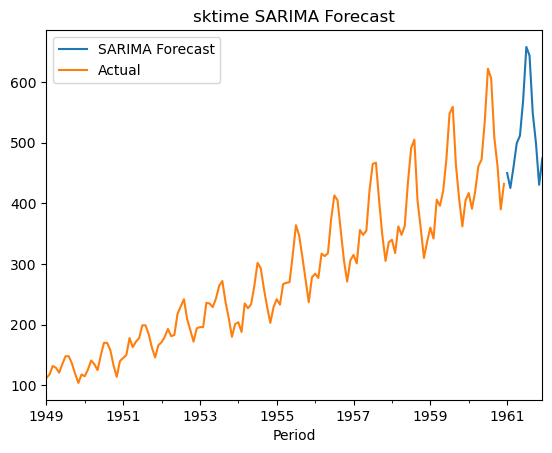

In [4]:
from sktime.forecasting.sarimax import SARIMAX

sarima = SARIMAX(order=(1,1,1), seasonal_order=(1,1,1,12))
sarima.fit(y)
y_sarima_pred = sarima.predict(fh)

y_sarima_pred.plot(label="SARIMA Forecast")
y.plot(label="Actual")
plt.legend()
plt.title("sktime SARIMA Forecast")
plt.show()

### Residual Diagnostics
Plot residuals and check for white noise behavior.

In [ ]:
sarima.res

SARIMAX(order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))

## Section 2: Forecasting with XGBoost
We will create lag features and use XGBoost to predict the time series.

In [8]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

df = y.to_frame(name='y')
df['lag1'] = df['y'].shift(1)
df['lag2'] = df['y'].shift(2)
df['rolling_mean'] = df['y'].rolling(3).mean()
df.dropna(inplace=True)

X = df[['lag1', 'lag2', 'rolling_mean']]
y_target = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y_target, shuffle=False, test_size=0.2)

model = XGBRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
print(f"MAE: {mae}")

MAE: 66.60968122811153


### Limitations of ML Forecasting
Try to predict values far beyond the observed range and observe how XGBoost flattens or fails.

In [9]:
# Discussed in markdown

### Time Series Split for Forecasting
Use `TimeSeriesSplit` to ensure training always precedes testing.

In [10]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_target.iloc[train_index], y_target.iloc[test_index]
    model = XGBRegressor()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"MAE: {mean_absolute_error(y_test, preds):.2f}")

MAE: 36.55
MAE: 29.59
MAE: 53.09
MAE: 45.20
MAE: 50.41


### ⏳ Time Series Splitting with sktime
Use sktime's `SlidingWindowSplitter` and `ExpandingWindowSplitter` to generate realistic train/test splits for forecasting.

In [11]:
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.metrics import mean_squared_error
from sktime.datasets import load_airline

y = load_airline()
fh = [1]  # forecasting horizon: 1-step ahead

splitter = SlidingWindowSplitter(fh=fh, window_length=36, step_length=12)
for train_idx, test_idx in splitter.split(y):
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    df = y_train.to_frame(name='y')
    df['lag1'] = df['y'].shift(1)
    df['lag2'] = df['y'].shift(2)
    df['rolling_mean'] = df['y'].rolling(3).mean()
    df.dropna(inplace=True)

    X_train = df[['lag1', 'lag2', 'rolling_mean']]
    y_train_final = df['y']

    X_test = pd.DataFrame({
        'lag1': [y.iloc[train_idx[-1]]],
        'lag2': [y.iloc[train_idx[-2]]],
        'rolling_mean': [y.iloc[train_idx[-3:]].mean()]
    })

    model = XGBRegressor()
    model.fit(X_train, y_train_final)
    pred = model.predict(X_test)

    true_val = y.iloc[test_idx].values[0]
    print(f"True: {true_val}, Predicted: {pred[0]:.2f}, Error: {abs(pred[0] - true_val):.2f}")

True: 171.0, Predicted: 177.21, Error: 6.21
True: 196.0, Predicted: 189.89, Error: 6.11
True: 204.0, Predicted: 192.69, Error: 11.31
True: 242.0, Predicted: 238.87, Error: 3.13
True: 284.0, Predicted: 292.29, Error: 8.29
True: 315.0, Predicted: 296.43, Error: 18.57
True: 340.0, Predicted: 369.82, Error: 29.82
True: 360.0, Predicted: 357.66, Error: 2.34
True: 417.0, Predicted: 396.95, Error: 20.05
